# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

In [26]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Срок сдачи:** 10 октября 2023, 23:59

**Максимально баллов:** 10

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups # поменял на openml, т.к. у меня новая версия

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cdist
from collections import Counter
from sklearn.neighbors import KDTree
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой.
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [30]:
# Дефолтно используется метрика Минковского, для 2d случае оно же евклидово расстояние

In [31]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'): # по дефолту евклидовая
        super(MyKNeighborsClassifier, self).__init__()
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric

    def fit(self, X, y):
        # обучение соcтоит в запоминании обучающей выборки
        self.train_data = X
        self.train_labels = y

    def predict(self, X, cv_mode=False):
        predictions = np.ones(X.shape[0], dtype='int')
        if self.algorithm == 'brute':
            if self.metric == 'euclidean':
                distances = cdist(X, self.train_data, 'minkowski', p=2) # (size_x, size_train)
            elif self.metric == 'cosine':
                distances = cdist(X, self.train_data, 'cosine') # (size_x, size_train)
            ind = distances.argsort()[:, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            tree = KDTree(self.train_data)
            if self.metric == 'euclidean':
                _, ind = tree.query(X, k=self.n_neighbors)
            elif self.metric == 'cosine':
                _, ind = tree.query(X, k=self.n_neighbors, metric='cosine')

        labels = np.array([self.train_labels[i] for i in ind])

        # оптимизация для задания с кросс-валидацией
        if cv_mode:
            return labels

        for i, cur_labels in enumerate(labels):
                counter = Counter(cur_labels).most_common(1)
                predictions[i] = int(counter[0][0])
        return predictions

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [32]:
iris = datasets.load_iris()

In [33]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [34]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [35]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [36]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза.
Для этого используем numpy.

In [37]:
%timeit clf.fit(X_train, y_train)

99.4 µs ± 2.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
%timeit my_clf.fit(X_train, y_train)

126 ns ± 3.08 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [39]:
%timeit clf.predict(X_test)

491 µs ± 15.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%timeit my_clf.predict(X_test)

84.7 µs ± 1.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


**Работает даже быстрее**

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза.
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn.

In [41]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [43]:
%time clf.fit(X_train, y_train)

Wall time: 1.01 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [44]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [45]:
%time clf.predict(X_test)

Wall time: 1.05 ms


array([2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 1])

In [46]:
%time my_clf.predict(X_test)

Wall time: 1.48 ms


array([2, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 1])

In [47]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [48]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [49]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(min_df=3, max_df=4) # ограничил по частотности для быстроты
tr_data = vectorizer.fit_transform(data)
X = tr_data.toarray()

**Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели**

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [51]:
# делит выборку на фолды для cv
def make_cv_folds(X, y, cv):
    X_folds = []
    y_folds = []
    fold_size = len(X) // cv
    for i in range(cv):
        if i == cv - 1: # в случае неделимости последний фолд будет больше
            X_folds.append(X[fold_size * i:])
            y_folds.append(y[fold_size * i:])
        else:
            X_folds.append(X[fold_size * i: fold_size * (i + 1)])
            y_folds.append(y[fold_size * i: fold_size * (i + 1)])

    return X_folds, y_folds

In [52]:
def optimal_k(X, y, cv=3, max_k=10, metric='euclidean'):
    # статистика точночти в зависимости от k
    stats_k = {k: [] for k in range(1, max_k + 1)}
    X_folds, y_folds = make_cv_folds(X, y, cv)

    # val_fold номер фолда для валидации
    for val_fold in range(cv):
        # собираем train
        X_train = []
        y_train = []
        for i in range(cv):
            if i != val_fold:
                X_train.extend(X_folds[i])
                y_train.extend(y_folds[i])
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # val
        X_val = X_folds[val_fold]
        y_val = y_folds[val_fold]

        # для текущего разбиения предсказываем один раз
        model = MyKNeighborsClassifier(n_neighbors=max_k, metric=metric)
        model.fit(X_train, y_train)
        labels = model.predict(X_val, cv_mode=True)

        # по предсказанным лейблам для каждого k считаем accuracy
        for k in range(1, max_k + 1):
            predictions = np.empty(X_val.shape[0], dtype='int')
            for i, cur_labels in enumerate(labels):
                counter = Counter(cur_labels[:k]).most_common(1)
                predictions[i] = int(counter[0][0])
            stats_k[k].append(accuracy_score(y_val, predictions))


    return stats_k

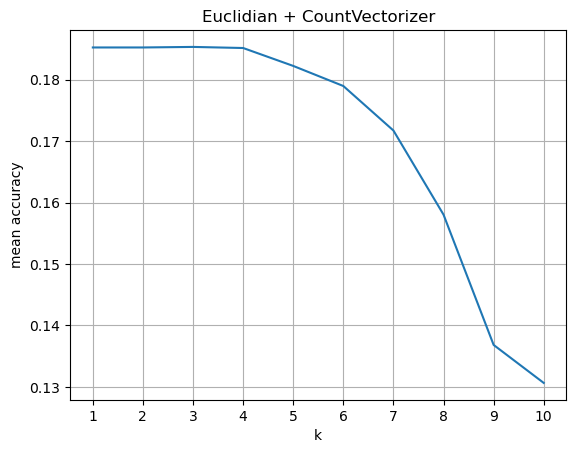

In [25]:
res = optimal_k(X, target)
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("Euclidian + CountVectorizer")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

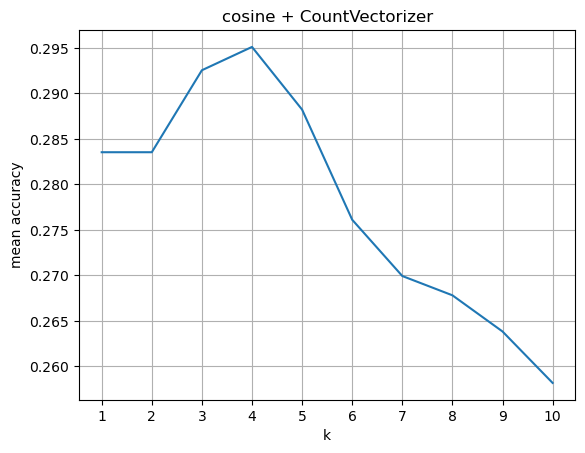

In [53]:
res = optimal_k(X, target, metric='cosine')
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("cosine + CountVectorizer")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

In [54]:
vectorizer = TfidfVectorizer(min_df=3, max_df=4)
tr_data = vectorizer.fit_transform(data)
X = tr_data.toarray()

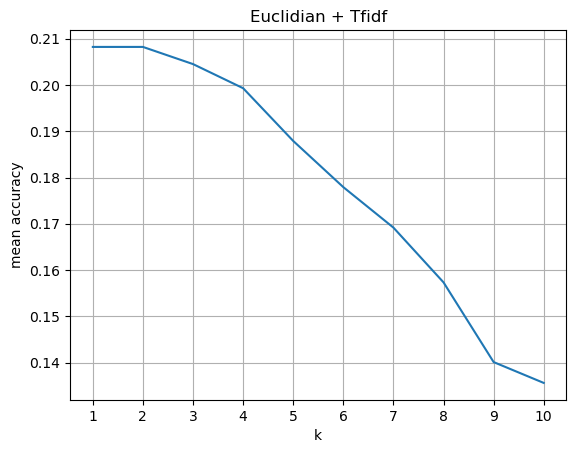

In [55]:
res = optimal_k(X, target)
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("Euclidian + Tfidf")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

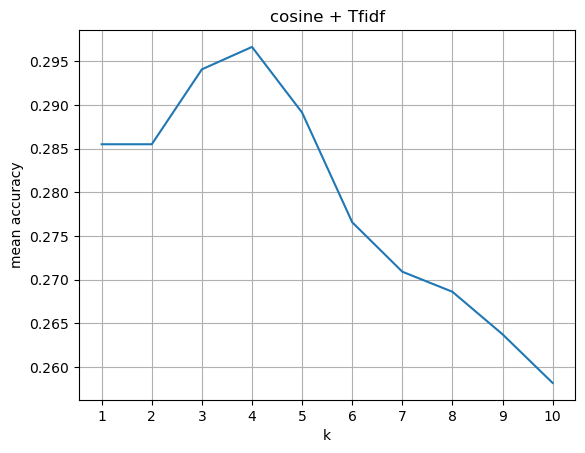

In [56]:
res = optimal_k(X, target, metric='cosine')
mean_acc = [np.mean(lst) for lst in res.values()]

plt.xticks(np.arange(1, 11))
plt.grid()
plt.title("cosine + Tfidf")
plt.xlabel("k")
plt.ylabel("mean accuracy")
plt.plot(np.arange(1, 11), mean_acc);

**Последняя модель показала самые выскокие метрики, будем для теста использовать ее. n_neighbors=4**

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [57]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [58]:
vectorizer = TfidfVectorizer(min_df=3, max_df=4)
tr_data = vectorizer.fit_transform(newsgroups['data'])
X_train = tr_data.toarray()
y_train = newsgroups['target']

In [59]:
model = MyKNeighborsClassifier(n_neighbors=4, metric='cosine')
model.fit(X_train, y_train)

In [60]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [61]:
test_data = vectorizer.transform(newsgroups['data'])
X_test = test_data.toarray()
y_test = newsgroups['target']

In [62]:
pred = model.predict(X_test)

In [63]:
print(accuracy_score(y_test, pred))

0.25955921402018056


**Accuracy получилась 0.26, что ниже, чем на кросс-валидации (~0.298). 
Качество может отличаться, во-первых, потому что как было сказано наборы текстовых данных в тестовой выборке отличаются и TfidfVectorizer может их хуже обрабатывать. Во-вторых, из-за того что тут мы использовали для обучения весь набор данных, и при всем наборе данных модель выбирает производит поиск соседей из большего набора, что может приводить к большим ошибкам и уменьшению качества**

# Линейные модели (5 баллов)

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно.

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается.
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array.





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены.

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***.

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [65]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """

    order = [i for i in range(X.shape[0])]
    if(shuffle): np.random.shuffle(order)
    i=0
    for i in range(0, len(order)//batch_size*batch_size, batch_size):
        indices = order[i:i+batch_size]
        X_batch = X[indices]
        y_batch = y[indices]
        yield (X_batch, y_batch)

In [66]:
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [67]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    ## Your code Here
    return 1/(1+np.exp(-np.clip(x, -100, 100)))


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg', batch_size=1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        batch_size - размер батча для batch_generator
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}
        self.model_type = model_type
        self.batch_size=batch_size
        self.logs={}

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        loss = 0
        self.predict(X_batch)
        preds = self.preds
        y = y_batch.reshape(-1,1)
        if(self.model_type=='lin_reg'):
            loss = ((y-preds)**2).mean()
        else:
            preds = np.clip(preds, sigmoid(-10), sigmoid(10))
            loss = -1/X_batch.shape[0]*np.sum(y*np.log(preds) + (1-y)*np.log(1-preds))

        if(self.C!=0):
            loss += 1/self.C*np.sum(self.weights**2)
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        self.predict(X_batch)
        preds = self.preds
        y = y_batch.reshape(-1,1)
        if(self.model_type=='lin_reg'):
            loss_grad = 2*((preds-y)*X_batch).mean(axis=0).reshape(-1,1)
        else:
            preds = np.clip(preds, sigmoid(-10), sigmoid(10))
            loss_grad = -(y*(1-preds)*X_batch + (1-y)*(-1)*preds*X_batch).mean(axis=0).reshape(-1,1)

        if(self.C!=0):
            loss_grad += 1/self.C*self.weights.reshape(-1,1)
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        new_grad = np.clip(new_grad, -np.float64(1e4), np.float64(1e4))
        self.weights -= self.alpha * new_grad
        pass

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        self.logs['losses']=[]
        self.logs['weights']=[]
        # Нужно инициализровать случайно веса
        self.weights = np.random.randn(X.shape[1]+1, 1)*(1/np.sqrt(X.shape[1]))
        cnt=0
        for n in range(0, self.max_epoch):
            # print(n)
            new_epoch_generator = self.batch_generator(X, y, shuffle=True, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = np.hstack([new_batch[0], np.ones((new_batch[0].shape[0], 1))])
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.logs['losses'].append(batch_loss)
                self.logs['weights'].append(np.abs(self.weights).mean())
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                cnt+=1

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''

        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot
        y_hat = X@self.weights
        if(self.model_type=='log_reg'): y_hat = sigmoid(y_hat)
        self.preds = y_hat.copy().reshape(-1,1)
        y_hat = ((y_hat>0.5) if(self.model_type=='log_reg') else (y_hat>0))
        return y_hat

Запустите обе регрессии на синтетических данных.


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [68]:
def plot_decision_boundary(clf, bounds=None):
    if bounds is not None:
        plt.xlim((bounds[0], bounds[1]))
        plt.ylim((bounds[2], bounds[3]))
    x = np.arange(-6, 8, 0.1)
    y = [(-x_*clf.weights[0] - clf.weights[-1])/clf.weights[1] for x_ in x]
    plt.plot(x,y)

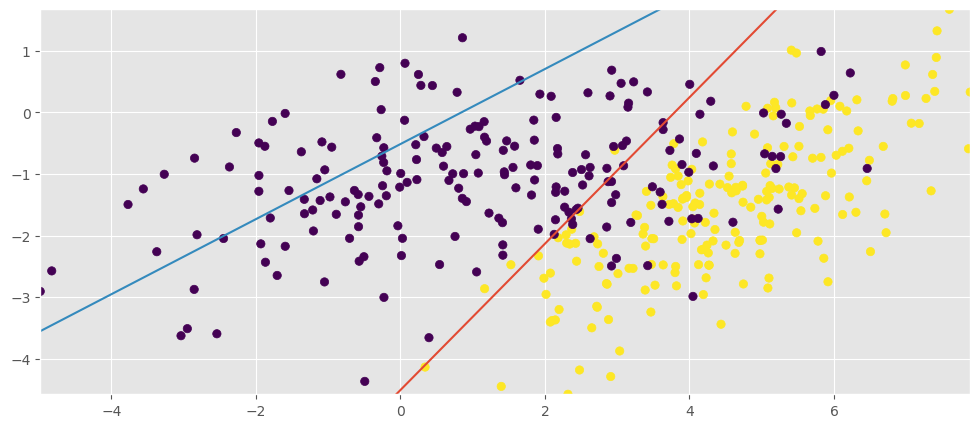

In [69]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

model = MySGDClassifier(batch_generator, max_epoch=10, model_type='log_reg', C=0, batch_size=1)
model.fit(X,y)
plot_decision_boundary(model, (X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()))

model = MySGDClassifier(batch_generator, max_epoch=10, model_type='lin_reg', C=0, batch_size=1)
model.fit(X,y)
plot_decision_boundary(model, (X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()))

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм.
Для этих заданий используйте датасет ниже.

In [70]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике.

$N$ можно брать 10, 50, 100 и т.д.

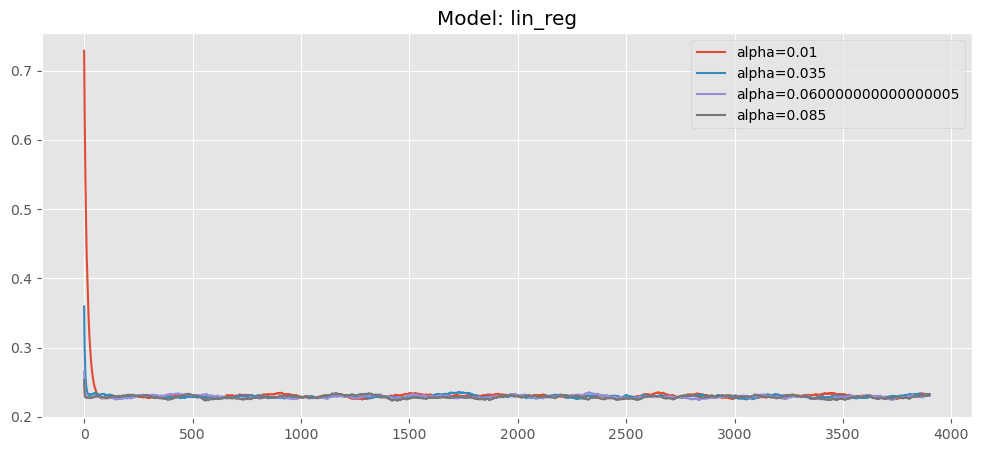

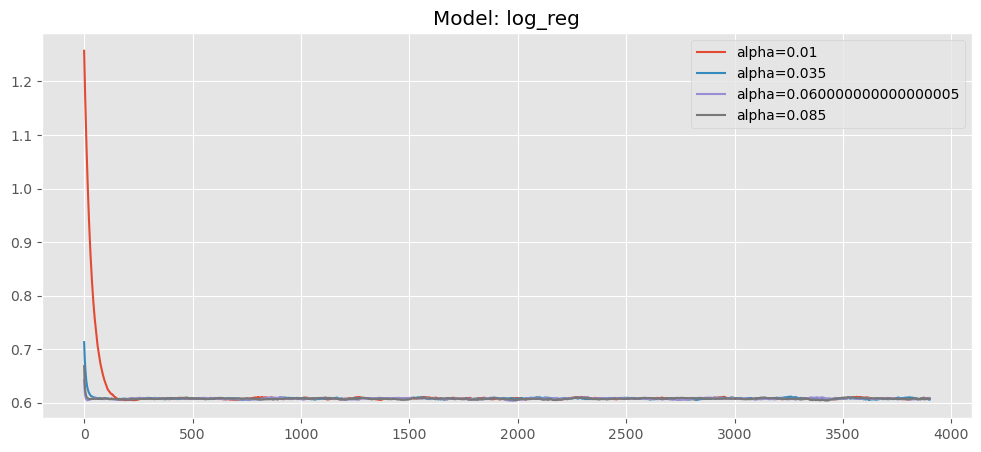

In [71]:
for tp in ['lin_reg', 'log_reg']:
    for C in [1]:
        for alpha in np.arange(1e-2, 1e-1+1e-2, 2.5e-2):
            model = MySGDClassifier(batch_generator, max_epoch=4, model_type=tp, C=C, alpha=alpha, batch_size=100)
            model.fit(X,y)
            N=100
            plt.plot([np.mean(model.logs['losses'][i:i+N]) for i in range(len(model.logs['losses'])-N)], label=f"alpha={alpha}");
    plt.legend()
    plt.title(f"Model: {tp}")
    plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)`

**Не сказал бы что, есть определенно идеальное значение alpha для лучшей сходимости. Но я считаю, что меньшее значение alpha ведет к более плавной и устойчивой сходимости, поэтому стоит взять значение alpha = 0.1**

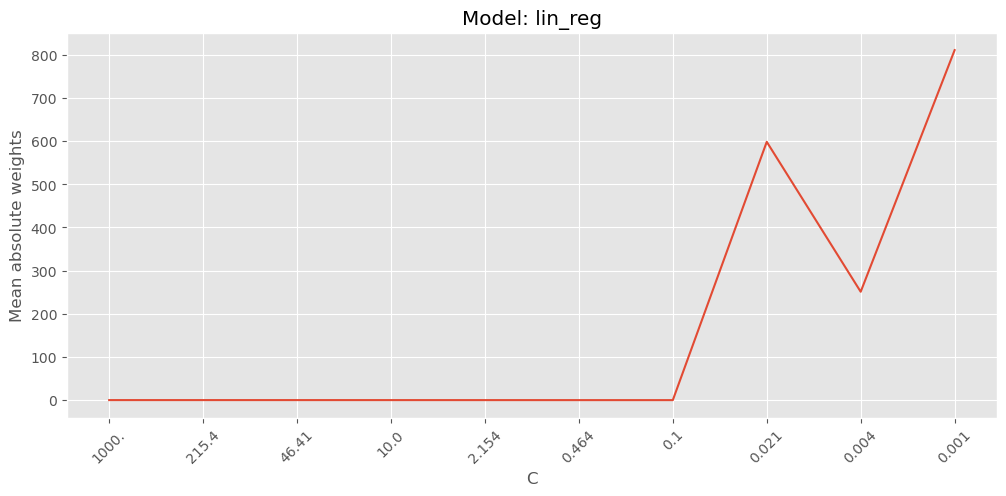

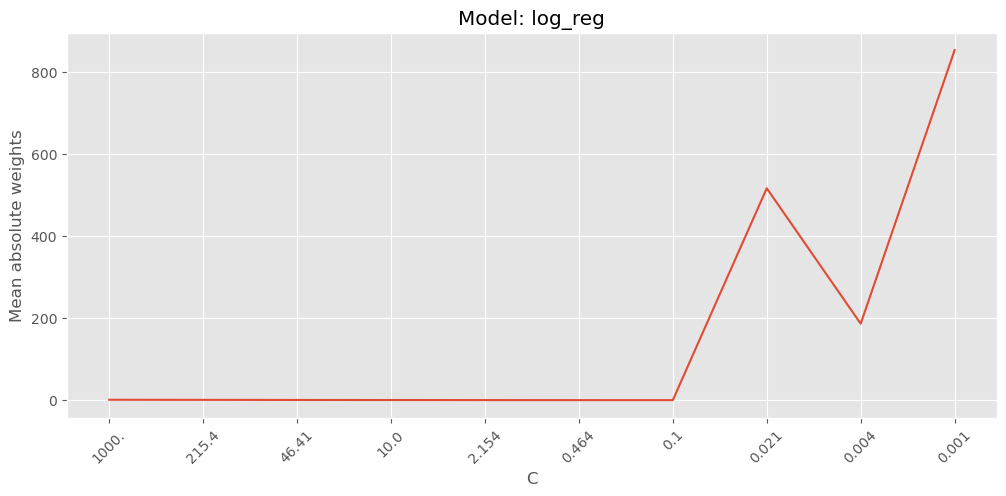

In [72]:
for tp in ['lin_reg', 'log_reg']:
    dots=[[],[]]
    for C in np.logspace(3, -3, 10):
        for alpha in [1e-1]:
            model = MySGDClassifier(batch_generator, max_epoch=10, model_type=tp, C=C, alpha=alpha, batch_size=100)
            model.fit(X,y)
            dots[0].append(str(C)[:5])
            dots[1].append(model.logs['weights'][-1])
            
    plt.plot(dots[1])
    plt.title(f"Model: {tp}")
    plt.xticks(range(len(dots[0])), dots[0], rotation=45)
    plt.xlabel('C')
    plt.ylabel('Mean absolute weights')
    plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса?

**При малых коэффициентах регуляризации выражение $({1}/{C}) R(w)$ становится очень большим по модулю, из-за чего веса начинают расходиться. Рассмотрим тот же график, но только для значений $C = 1000 .. 0.1$**

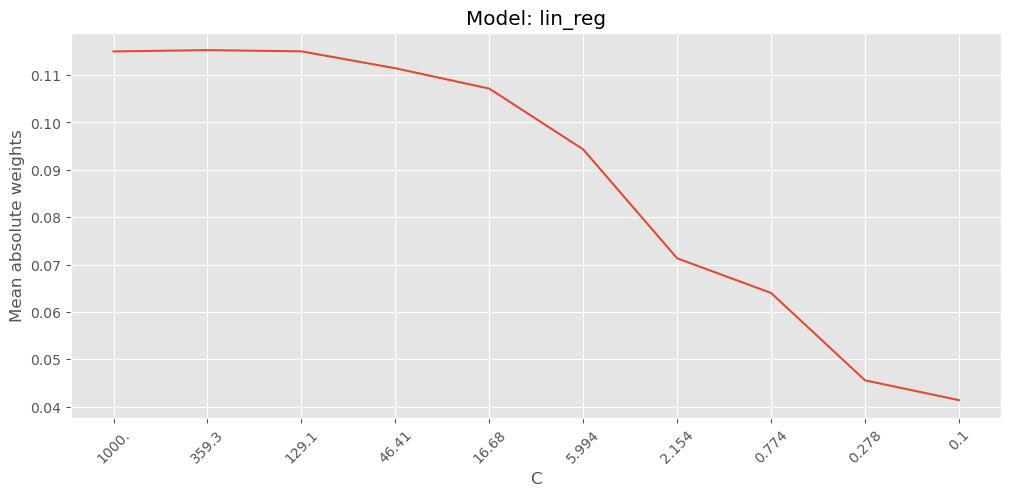

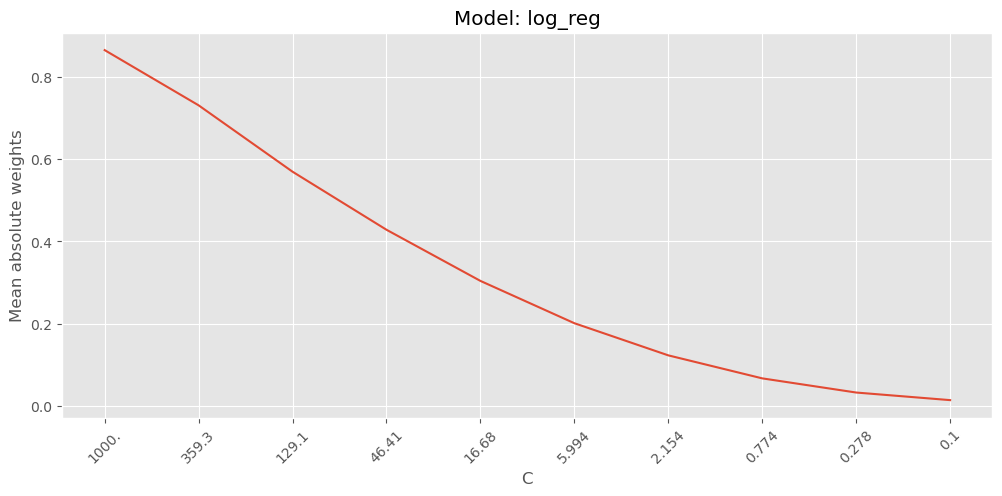

In [73]:
for tp in ['lin_reg', 'log_reg']:
    dots=[[],[]]
    for C in np.logspace(3, -1, 10):
        for alpha in [1e-1]:
            model = MySGDClassifier(batch_generator, max_epoch=10, model_type=tp, C=C, alpha=alpha, batch_size=100)
            model.fit(X,y)
            dots[0].append(str(C)[:5])
            dots[1].append(model.logs['weights'][-1])
    plt.plot(dots[1])
    plt.title(f"Model: {tp}")
    plt.xticks(range(len(dots[0])), dots[0], rotation=45)
    plt.xlabel('C')
    plt.ylabel('Mean absolute weights')
    plt.show()

**При достаточно больших значениях $C$
 веса модели уменьшаются при уменьшении $C$
, как и ожидалось**